CLASSIFICATION BINAIRE - COMPARAISON DES FONCTIONS DE COÛT
Distribution des classes (train): [470 330]
Distribution des classes (test): [127  73]

Fonction: BINARY_CROSS_ENTROPY
TRAIN - Accuracy: 0.8812, F1: 0.8319
TEST  - Accuracy: 0.8900, F1: 0.8226
        Précision: 1.0000, Rappel: 0.6986

Matrice de confusion:
                  Prédit 0  Prédit 1
Vraiment 0           127         0
Vraiment 1            22        51

Fonction: FOCAL
TRAIN - Accuracy: 0.7250, F1: 0.5000
TEST  - Accuracy: 0.7700, F1: 0.5400
        Précision: 1.0000, Rappel: 0.3699

Matrice de confusion:
                  Prédit 0  Prédit 1
Vraiment 0           127         0
Vraiment 1            46        27

Fonction: HINGE
TRAIN - Accuracy: 0.5875, F1: 0.0000
TEST  - Accuracy: 0.6350, F1: 0.0000
        Précision: 0.0000, Rappel: 0.0000

Matrice de confusion:
                  Prédit 0  Prédit 1
Vraiment 0           127         0
Vraiment 1            73         0

 Graphique sauvegardé: classification_comparison.

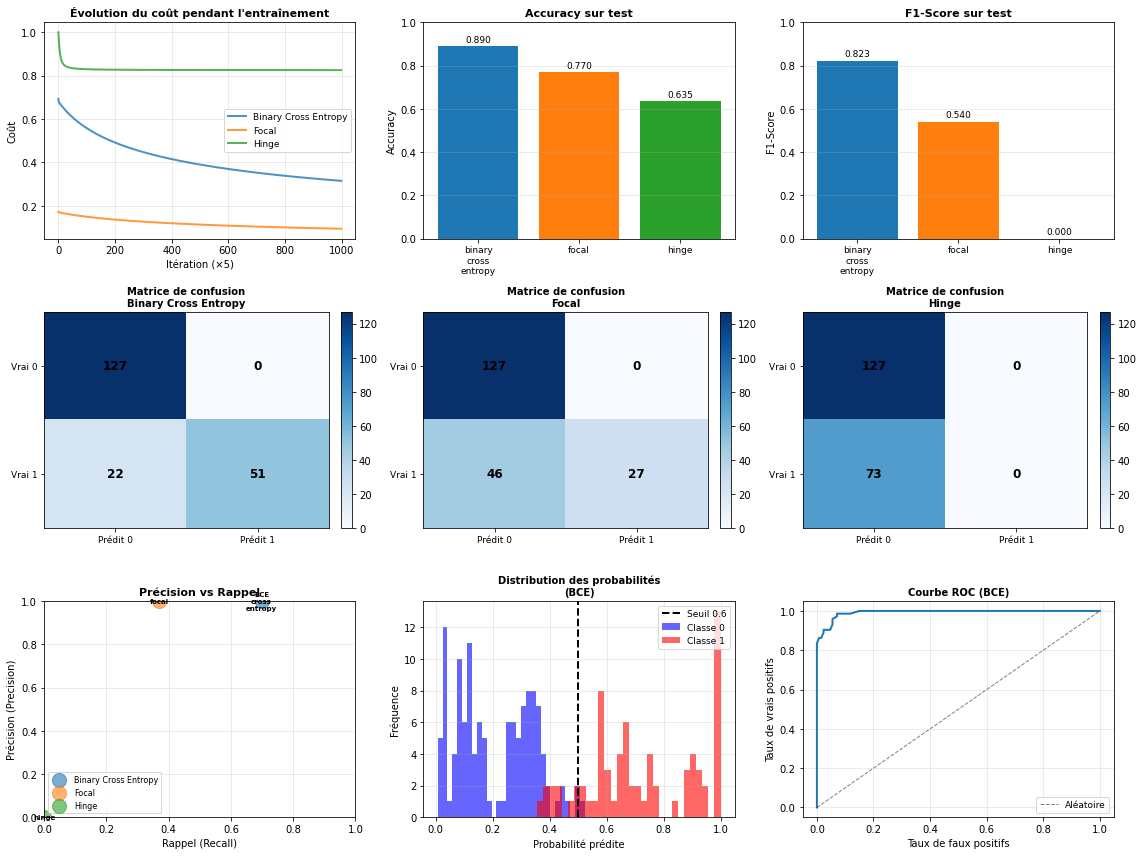


RÉSUMÉ DES PERFORMANCES
Meilleure Accuracy: BINARY_CROSS_ENTROPY (0.8900)
Meilleur F1-Score: BINARY_CROSS_ENTROPY (0.8226)

Coefficients (Binary Cross-Entropy):
[-6.606  -0.3889 -0.0553  0.2405 14.3473 -0.6695  0.0157 -0.1782  0.3296
 -0.0147  0.0843 -0.4518  0.0236 -0.2707 -0.9303]


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Lecture des données
df = pd.read_csv('synthetic_2data_1000.csv')

x = df[['Age', 'Gender', 'Level', 'GPA', 'Teaching_Quality', 'Lab_Sessions', 
        'Structured_Plan','Living_Situation', 'Sleep_Hours_Daily', 'Physical_Activity', 
        'Success_Factors_Len', 'Improvement_Suggestions_Len','Study_Hours_Weekly', 
        'Class_Regularity']].values
y = df['Decision'].values

X_train = x[:800]
y_train = y[:800]
X_test = x[800:]
y_test = y[800:]

# Normalisation Min-Max

X_min = X_train.min(axis=0)
X_max = X_train.max(axis=0)

X_norm = (X_train - X_min) / (X_max - X_min + 1e-8)
X_test_norm = (X_test - X_min) / (X_max - X_min + 1e-8)


# Ajout du bias
X_b = np.c_[np.ones(X_norm.shape[0]), X_norm]
X_test_b = np.c_[np.ones(X_test_norm.shape[0]), X_test_norm]

# FONCTION SIGMOÏDE

def sigmoid(z):
    """Fonction sigmoïde pour régression logistique"""
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))  # clip pour éviter overflow

# FONCTIONS DE COÛT POUR CLASSIFICATION

def binary_cross_entropy(y_true, y_pred_proba, epsilon=1e-15):
    """Entropie croisée binaire (log loss)"""
    y_pred_proba = np.clip(y_pred_proba, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred_proba) + (1 - y_true) * np.log(1 - y_pred_proba))

def hinge_loss(y_true, y_pred_proba):
    """Hinge Loss (SVM-like)"""
    # Convertir proba en [-1, 1]
    y_true_adjusted = 2 * y_true - 1
    decision_values = 2 * y_pred_proba - 1
    return np.mean(np.maximum(0, 1 - y_true_adjusted * decision_values))

def focal_loss(y_true, y_pred_proba, gamma=2.0, epsilon=1e-15):
    """Focal Loss - pour déséquilibre de classes"""
    y_pred_proba = np.clip(y_pred_proba, epsilon, 1 - epsilon)
    ce = -(y_true * np.log(y_pred_proba) + (1 - y_true) * np.log(1 - y_pred_proba))
    p_t = y_true * y_pred_proba + (1 - y_true) * (1 - y_pred_proba)
    return np.mean((1 - p_t) ** gamma * ce)

# MÉTRIQUES D'ÉVALUATION

def accuracy(y_true, y_pred):
    """Exactitude"""
    return np.mean(y_true == y_pred)

def precision(y_true, y_pred):
    """Précision"""
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    return tp / (tp + fp + 1e-10)

def recall(y_true, y_pred):
    """Rappel (sensibilité)"""
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    return tp / (tp + fn + 1e-10)

def f1_score(y_true, y_pred):
    """F1-Score"""
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec + 1e-10)

def confusion_matrix(y_true, y_pred):
    """Matrice de confusion"""
    tn = np.sum((y_pred == 0) & (y_true == 0))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    tp = np.sum((y_pred == 1) & (y_true == 1))
    return np.array([[tn, fp], [fn, tp]])

# DESCENTE DE GRADIENT POUR CLASSIFICATION

def gradient_descent_classification(X, y, cost_function='binary_cross_entropy', 
                                   lr=0.1, n_iters=5000, verbose=True):
    """
    Descente de gradient pour classification binaire
    
    cost_function: 'binary_cross_entropy', 'hinge', 'focal'
    """
    m = len(y)
    theta = np.zeros(X.shape[1])
    costs = []
    
    for i in range(n_iters):
        z = X.dot(theta)
        y_pred_proba = sigmoid(z)
        
        # Calcul du gradient selon la fonction de coût
        if cost_function == 'binary_cross_entropy':
            gradients = (1/m) * X.T.dot(y_pred_proba - y)
            cost = binary_cross_entropy(y, y_pred_proba)
            
        elif cost_function == 'focal':
            gamma = 2.0
            p_t = y * y_pred_proba + (1 - y) * (1 - y_pred_proba)
            alpha_t = y  # simplified
            focal_weight = (1 - p_t) ** gamma
            gradients = (1/m) * X.T.dot(focal_weight * (y_pred_proba - y))
            cost = focal_loss(y, y_pred_proba, gamma)
            
        elif cost_function == 'hinge':
            # Approximation différentiable du hinge loss
            y_adjusted = 2 * y - 1
            decision = 2 * y_pred_proba - 1
            margin = y_adjusted * decision
            gradients = (1/m) * X.T.dot(np.where(margin < 1, 
                                                  -y_adjusted * 2 * y_pred_proba * (1 - y_pred_proba), 
                                                  0))
            cost = hinge_loss(y, y_pred_proba)
        
        theta -= lr * gradients
        costs.append(cost)
        
        if verbose and i % 1000 == 0:
            acc = accuracy(y, (y_pred_proba >= 0.5).astype(int))
            print(f"Itération {i}, Coût ({cost_function}): {cost:.4f}, Accuracy: {acc:.4f}")
    
    return theta, costs

# ENTRAÎNEMENT ET COMPARAISON

print("CLASSIFICATION BINAIRE - COMPARAISON DES FONCTIONS DE COÛT")
print(f"Distribution des classes (train): {np.bincount(y_train.astype(int))}")
print(f"Distribution des classes (test): {np.bincount(y_test.astype(int))}")

results = {}
cost_functions = ['binary_cross_entropy', 'focal', 'hinge']

for cf in cost_functions:
    print(f"\n{'='*60}")
    print(f"Fonction: {cf.upper()}")
    print('='*60)
    
    theta, costs = gradient_descent_classification(
        X_b, y_train, 
        cost_function=cf, 
        lr=0.165, 
        n_iters=5000, 
        verbose=False
    )
    
    # Prédictions
    y_train_proba = sigmoid(X_b.dot(theta))
    y_train_pred = (y_train_proba >= 0.6).astype(int)
    
    y_test_proba = sigmoid(X_test_b.dot(theta))
    y_test_pred = (y_test_proba >= 0.6).astype(int)
    
    # Métriques train
    train_acc = accuracy(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    
    # Métriques test
    test_acc = accuracy(y_test, y_test_pred)
    test_prec = precision(y_test, y_test_pred)
    test_rec = recall(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_conf = confusion_matrix(y_test, y_test_pred)
    
    results[cf] = {
        'theta': theta,
        'costs': costs,
        'train_acc': train_acc,
        'train_f1': train_f1,
        'test_acc': test_acc,
        'test_prec': test_prec,
        'test_rec': test_rec,
        'test_f1': test_f1,
        'test_conf': test_conf,
        'y_test_proba': y_test_proba,
        'y_test_pred': y_test_pred
    }
    
    print(f"TRAIN - Accuracy: {train_acc:.4f}, F1: {train_f1:.4f}")
    print(f"TEST  - Accuracy: {test_acc:.4f}, F1: {test_f1:.4f}")
    print(f"        Précision: {test_prec:.4f}, Rappel: {test_rec:.4f}")
    print(f"\nMatrice de confusion:")
    print(f"                  Prédit 0  Prédit 1")
    print(f"Vraiment 0        {test_conf[0,0]:6d}    {test_conf[0,1]:6d}")
    print(f"Vraiment 1        {test_conf[1,0]:6d}    {test_conf[1,1]:6d}")

# VISUALISATIONS

fig = plt.figure(figsize=(16, 12))

# 1. Courbes de coût
ax1 = plt.subplot(3, 3, 1)
for cf in cost_functions:
    plt.plot(results[cf]['costs'][::5], label=cf.replace('_', ' ').title(), alpha=0.8, linewidth=2)
plt.xlabel('Itération (×5)', fontsize=10)
plt.ylabel('Coût', fontsize=10)
plt.title('Évolution du coût pendant l\'entraînement', fontsize=11, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# 2. Comparaison Accuracy
ax2 = plt.subplot(3, 3, 2)
test_accs = [results[cf]['test_acc'] for cf in cost_functions]
bars = plt.bar(range(len(cost_functions)), test_accs, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.xticks(range(len(cost_functions)), 
           [cf.replace('_', '\n') for cf in cost_functions], fontsize=9)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy sur test', fontsize=11, fontweight='bold')
plt.ylim([0, 1])
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{test_accs[i]:.3f}', ha='center', va='bottom', fontsize=9)
plt.grid(True, alpha=0.3, axis='y')

# 3. Comparaison F1-Score
ax3 = plt.subplot(3, 3, 3)
test_f1s = [results[cf]['test_f1'] for cf in cost_functions]
bars = plt.bar(range(len(cost_functions)), test_f1s, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.xticks(range(len(cost_functions)), 
           [cf.replace('_', '\n') for cf in cost_functions], fontsize=9)
plt.ylabel('F1-Score', fontsize=10)
plt.title('F1-Score sur test', fontsize=11, fontweight='bold')
plt.ylim([0, 1])
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{test_f1s[i]:.3f}', ha='center', va='bottom', fontsize=9)
plt.grid(True, alpha=0.3, axis='y')

# 4-6. Matrices de confusion
for idx, cf in enumerate(cost_functions):
    ax = plt.subplot(3, 3, 4 + idx)
    conf = results[cf]['test_conf']
    im = plt.imshow(conf, cmap='Blues', aspect='auto')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    
    for i in range(2):
        for j in range(2):
            text = plt.text(j, i, conf[i, j],
                          ha="center", va="center", color="black", fontsize=12, fontweight='bold')
    
    plt.xticks([0, 1], ['Prédit 0', 'Prédit 1'], fontsize=9)
    plt.yticks([0, 1], ['Vrai 0', 'Vrai 1'], fontsize=9)
    plt.title(f'Matrice de confusion\n{cf.replace("_", " ").title()}', 
              fontsize=10, fontweight='bold')

# 7. Précision vs Rappel
ax7 = plt.subplot(3, 3, 7)
precs = [results[cf]['test_prec'] for cf in cost_functions]
recs = [results[cf]['test_rec'] for cf in cost_functions]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for i, cf in enumerate(cost_functions):
    plt.scatter(recs[i], precs[i], s=200, alpha=0.6, color=colors[i],
               label=cf.replace('_', ' ').title())
    plt.text(recs[i], precs[i], cf.replace('_', '\n').replace('binary', 'BCE'), 
             ha='center', va='center', fontsize=7, fontweight='bold')
plt.xlabel('Rappel (Recall)', fontsize=10)
plt.ylabel('Précision (Precision)', fontsize=10)
plt.title('Précision vs Rappel', fontsize=11, fontweight='bold')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(True, alpha=0.3)
plt.legend(fontsize=8, loc='lower left')

# 8. Distribution des probabilités prédites (Binary Cross-Entropy)
ax8 = plt.subplot(3, 3, 8)
cf_main = 'binary_cross_entropy'
y_proba = results[cf_main]['y_test_proba']
plt.hist(y_proba[y_test == 0], bins=30, alpha=0.6, label='Classe 0', color='blue')
plt.hist(y_proba[y_test == 1], bins=30, alpha=0.6, label='Classe 1', color='red')
plt.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Seuil 0.6')
plt.xlabel('Probabilité prédite', fontsize=10)
plt.ylabel('Fréquence', fontsize=10)
plt.title(f'Distribution des probabilités\n(BCE)', fontsize=10, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# 9. Courbe ROC simplifiée (pour BCE)
ax9 = plt.subplot(3, 3, 9)
cf_main = 'binary_cross_entropy'
y_proba = results[cf_main]['y_test_proba']
thresholds = np.linspace(0, 1, 100)
tprs = []
fprs = []
for thresh in thresholds:
    y_pred = (y_proba >= thresh).astype(int)
    tp = np.sum((y_pred == 1) & (y_test == 1))
    fp = np.sum((y_pred == 1) & (y_test == 0))
    tn = np.sum((y_pred == 0) & (y_test == 0))
    fn = np.sum((y_pred == 0) & (y_test == 1))
    tpr = tp / (tp + fn + 1e-10)
    fpr = fp / (fp + tn + 1e-10)
    tprs.append(tpr)
    fprs.append(fpr)
plt.plot(fprs, tprs, linewidth=2, color='#1f77b4')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Aléatoire')
plt.xlabel('Taux de faux positifs', fontsize=10)
plt.ylabel('Taux de vrais positifs', fontsize=10)
plt.title('Courbe ROC (BCE)', fontsize=10, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=9)

plt.tight_layout()
plt.savefig('classification_comparison.png', dpi=150, bbox_inches='tight')
print("\n" + "="*80)
print(" Graphique sauvegardé: classification_comparison.png")
plt.show()

# RÉSUMÉ FINAL
print("\n" + "="*80)
print("RÉSUMÉ DES PERFORMANCES")
best_acc = max(results.items(), key=lambda x: x[1]['test_acc'])
best_f1 = max(results.items(), key=lambda x: x[1]['test_f1'])
print(f"Meilleure Accuracy: {best_acc[0].upper()} ({best_acc[1]['test_acc']:.4f})")
print(f"Meilleur F1-Score: {best_f1[0].upper()} ({best_f1[1]['test_f1']:.4f})")
print("\nCoefficients (Binary Cross-Entropy):")
print(results['binary_cross_entropy']['theta'].round(4))

In [2]:
theta

array([-2.26565293, -0.68593191, -1.1516138 , -0.40834631, -0.12319185,
       -1.37509531, -0.78476356, -0.77402494, -0.38901491, -0.75836516,
       -0.8924167 , -0.12232186, -0.17823268, -0.12772104, -1.77001219])

In [4]:
print("MIN VALUES:")
print(X_train.min(axis=0))
print("\nMAX VALUES:")
print(X_train.max(axis=0))

MIN VALUES:
[16.  0.  1.  7.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

MAX VALUES:
[ 30.     1.     5.    17.05   3.     1.     2.     2.     1.     2.
 418.   758.   230.     6.  ]


['X_max.pkl']

In [5]:
import joblib

# Récupérer le modèle Binary Cross Entropy
theta_bce = results['binary_cross_entropy']['theta']

# Sauvegarder theta
joblib.dump(theta_bce, 'theta_bce.pkl')
print("Modèle theta sauvegardé sous 'theta_bce.pkl'")


 Modèle theta sauvegardé sous 'theta_bce.pkl'


In [6]:
scaler = {
    'min': X_train.min(axis=0),
    'max': X_train.max(axis=0)
}

joblib.dump(scaler, 'scaler.pkl')
print("✓ Scaler sauvegardé sous 'scaler.pkl'")


Scaler sauvegardé sous 'scaler.pkl'


In [3]:
results

{'binary_cross_entropy': {'theta': array([-6.60598966, -0.38887618, -0.05527884,  0.24046097, 14.34727348,
         -0.66947624,  0.0156859 , -0.17815602,  0.32959119, -0.01474053,
          0.08425352, -0.45180327,  0.02356171, -0.2706575 , -0.9303213 ]),
  'costs': [0.6931471805599452,
   0.6891827589986648,
   0.6863444920940429,
   0.6842776026845385,
   0.6827392275177053,
   0.6815633171469144,
   0.6806363408368122,
   0.6798806220497841,
   0.6792429596232685,
   0.6786868720817477,
   0.6781873123922872,
   0.6777270635796235,
   0.6772942776353922,
   0.6768807926684635,
   0.6764809805047131,
   0.6760909564107171,
   0.6757080364350339,
   0.6753303643378197,
   0.6749566548400872,
   0.6745860167628652,
   0.6742178311011554,
   0.6738516669121136,
   0.6734872232560448,
   0.6731242891008589,
   0.6727627156205348,
   0.672402397049705,
   0.6720432574476735,
   0.6716852415455145,
   0.6713283084152729,
   0.6709724270902594,
   0.6706175735345647,
   0.6702637285457621,

In [4]:
results['binary_cross_entropy']['theta']

array([-6.60598966, -0.38887618, -0.05527884,  0.24046097, 14.34727348,
       -0.66947624,  0.0156859 , -0.17815602,  0.32959119, -0.01474053,
        0.08425352, -0.45180327,  0.02356171, -0.2706575 , -0.9303213 ])